In [1]:
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
from __future__ import absolute_import,print_function,division
from keras import layers
import keras
import keras.backend as K
from pylab import rcParams
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt 
import numpy as np 
import os
import PIL
import imageio
import glob
import time 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
%matplotlib inline
from sklearn.utils import shuffle
import random
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mmd2

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
pus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)  # 设置显存按需申请
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]) 

In [4]:
seq_len = 30
num_singal = 29
seq_step = 1
value = 0
width = num_singal
height = seq_len
channels = 1
epoch_dura = 100
owner="D"
feature="29"
dp=2000

In [5]:
def pca(samples):
    X_n = samples
    ####################################
    ###################################
    # -- the best PC dimension is chosen pc=6 -- #
    n_components = num_singal
    pca = PCA(n_components)
    pca.fit(X_n)
    T_n = pca.transform(X_n)
    ex_var = pca.explained_variance_ratio_
    pc = pca.components_
    # projected values on the principal component
    T_n = np.matmul(X_n, pc.transpose(1, 0))
    samples = T_n
    return samples

In [6]:
def norm(train):
    m, n = train.shape  # m=562387, n=35
    # normalization
    for i in range(n):
        # print('i=', i)
        A = max(train[:, i])-min(train[:, i])
        if A != 0:
#             train[:,i] = train[:,i]-train[:,i].mean()
#             train[:,i] = train[:,i]/train[:,i].std()
            train[:,i] = (train[:,i]-train[:,i].min())/(train[:,i].max()-train[:,i].min())           
#             train[:,i] = train[:,i]*(train[:,i].max()-train[:,i].min())+train[:,i].min()
#             train[:, i] /= max(train[:, i])
#             # scale from -1 to 1
#             train[:, i] = 2 * train[:, i] - 1
        else:
            train[:, i] = train[:, i]
    return train

In [7]:
scaler = MinMaxScaler()
train_data=np.load('./data/dataD_cityraod_29.npy',allow_pickle=True)
train_data1 = scaler.fit_transform(train_data)
train_data1 = pca(train_data1)
####################test data################################
test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
test_data1 = scaler.fit_transform(test_data1)
test_data1 = pca(test_data1)

test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
test_data2 = scaler.fit_transform(test_data2)
test_data2 = pca(test_data2)

test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
test_data3 = scaler.fit_transform(test_data3)
test_data3 = pca(test_data3)

test_data = np.vstack((test_data1,test_data2))
test_data = np.vstack((test_data,test_data3))
#############################################################
train_data_driver = train_data1
train_data_drivertest = np.load('./data/dataD_highway_29.npy',allow_pickle=True)
train_data_drivertest = scaler.fit_transform(train_data_drivertest)
train_data_drivertest =pca(train_data_drivertest)

In [8]:
# scaler = MinMaxScaler()
# # scaler = StandardScaler()
# train_data=np.load('./data/dataD_'+feature+'.npy',allow_pickle=True)
# train_data1 = scaler.fit_transform(train_data)
# # train_data1=norm(train_data)
# train_data1 = pca(train_data1)
# ####################test data################################
# test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
# test_data1 = scaler.fit_transform(test_data1)
# # test_data=norm(test_data)
# test_data1 = pca(test_data1)
# # test_data= test_data[test_data.shape[0]//2:,:]

# test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
# test_data2 = scaler.fit_transform(test_data2)
# # test_data=norm(test_data)
# test_data2 = pca(test_data2)
# # test_data= test_data[test_data.shape[0]//2:,:]

# test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
# test_data3 = scaler.fit_transform(test_data3)
# # test_data=norm(test_data)
# test_data3 = pca(test_data3)
# # test_data= test_data[test_data.shape[0]//2:,:]

# test_data = np.vstack((test_data1,test_data2))
# test_data = np.vstack((test_data,test_data3))
# #############################################################

# train_data_driver = train_data1[:train_data.shape[0]//2,:] #6621
# # train_data_driver=norm(train_data_driver)
# # train_data_driver = pca(train_data_driver)

# train_data_drivertest = train_data1[train_data.shape[0]//2:,:] 
# # train_data_drivertest=norm(train_data_drivertest)
# # train_data_drivertest = pca(train_data_drivertest)

In [9]:
train_data1.shape

(3693, 29)

In [10]:
def driver(seq_len, seq_step, num_singal,value):
    ##########################################################
#     train=np.load('./data/dataD.npy',allow_pickle=True)
    train = train_data_driver
    ##########################################################
#     train = norm(train)
#     train = pca(train)
    
    labels = np.full(shape=(len(train)),fill_value=value)
    samples = train

    num_samples = (samples.shape[0] - seq_len) // seq_step
    aa = np.empty([num_samples, seq_len, num_singal])
    bb = np.empty([num_samples, seq_len, 1])


    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa[j, :, i] = samples[(j * seq_step):(j * seq_step + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa[j, :, k])-min(aa[j, :, k])
#             if A != 0:
#                 aa[j, :, k] = (aa[j, :, k]-aa[j, :, k].min())/(aa[j, :, k].max()-aa[j, :, k].min())
#             else:
#                 aa[j, :, k] = aa[j, :, k]    

    samples = aa
#     index = [i for i in range(len(samples))]
#     random.shuffle(index)
#     samples = samples[index]
#     samples = samples[0:dp]
#     samples = np.reshape(samples,[samples.shape[0],samples.shape[1],samples.shape[2],1])
    labels = bb

    return samples, labels

In [11]:
dataD_train,labelD = driver(seq_len, seq_step, num_singal,value)

In [12]:
def driver_test():    
#     dataD=np.load('./data/dataD.npy',allow_pickle=True)
    dataD=train_data_drivertest#train_data_drivertest[:6622,]
#     dataB=np.load('./data/dataB.npy',allow_pickle=True)
#     dataH=np.load('./data/dataH.npy',allow_pickle=True)
    dataA=test_data#train_data_drivertest[6622:,]
#     dataH = dataH[2000:,:]
#     dataB=dataB[:3000,:]
#     dataA=np.vstack((dataA,dataB))
#     dataA=np.vstack((dataA,dataH))
#     dataA = dataA[1000:,:]
    dataD_normal = dataD
    dataD_anormaly=dataA
    
#     dataD_contrib = np.vstack((dataD_normal,dataD_anormaly))
#     dataD_contrib = norm(dataD_contrib)
#     dataD_contrib = pca(dataD_contrib)
    label_0 = np.full(shape=(len(dataD_normal)),fill_value=0)
    label_1 = np.full(shape=(len(dataD_anormaly)),fill_value=1)
#     idx = np.asarray(list(range(0, dataD_contrib.shape[0])))
    
#     dataD_normal = dataD_contrib[:dataD_normal.shape[0],:]
#     dataD_anormaly = dataD_contrib[dataD_normal.shape[0]:,:]

    num_samples_0 = (dataD_normal.shape[0] - seq_len) // 1
    aa_0 = np.empty([num_samples_0, seq_len, num_singal])
    bb_0 = np.empty([num_samples_0, seq_len, 1])
    bbb_0 = np.empty([num_samples_0, seq_len, 1])
    for j in range(num_samples_0):
        bb_0[j, :, :] = np.reshape(label_0[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_0[j, :, i] = dataD_normal[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_0[j, :, k])-min(aa_0[j, :, k])
#             if A != 0:
#                 aa_0[j, :, k] = (aa_0[j, :, k]-aa_0[j, :, k].min())/(aa_0[j, :, k].max()-aa_0[j, :, k].min())
#             else:
#                 aa_0[j, :, k] = aa_0[j, :, k]

    num_samples_1 = (dataD_anormaly.shape[0] - seq_len) // 1
    aa_1 = np.empty([num_samples_1, seq_len, num_singal])
    bb_1 = np.empty([num_samples_1, seq_len, 1])
    bbb_1 = np.empty([num_samples_1, seq_len, 1])
    for j in range(num_samples_1):
        bb_1[j, :, :] = np.reshape(label_1[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_1[j, :, i] = dataD_anormaly[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_1[j, :, k])-min(aa_1[j, :, k])
#             if A != 0:
#                 aa_1[j, :, k] = (aa_1[j, :, k]-aa_1[j, :, k].min())/(aa_1[j, :, k].max()-aa_1[j, :, k].min())
#             else:
#                 aa_1[j, :, k] = aa_1[j, :, k]

        
        
#     aa_1_A = aa_1[:len(aa_1)//2,:]
#     aa_1_B = aa_1[len(aa_1)//2:,:]
#     bb_1_A = bb_1[:len(aa_1)//2,:]
#     bb_1_B = bb_1[len(aa_1)//2:,:]
#     dataD_test = np.insert(aa_0,1500,aa_1,axis=0)
#     dataD_test = np.insert(dataD_test,5880,aa_1_B,axis=0)
#     labelD_test = np.insert(bb_0,1500,bb_1,axis=0)
#     labelD_test = np.insert(labelD_test,5880,bb_1_B,axis=0)
    dataD_test = np.concatenate((aa_0,aa_1),axis=0)
    labelD_test= np.concatenate((bb_0,bb_1),axis=0)
    labelD_test = np.reshape(labelD_test,[labelD_test.shape[0],labelD_test.shape[1]])
    labelD_test = np.sum(labelD_test,1)
    labelD_test[labelD_test > 1] = 1

    index = [i for i in range(len(dataD_test))]
    random.shuffle(index)
    dataD_test = dataD_test[index]
    labelD_test = labelD_test[index]
    np.save("./score/label_owner"+owner+".npy", labelD_test)

#     dataD_test = np.reshape(dataD_test,[dataD_test.shape[0],dataD_test.shape[1],dataD_test.shape[2],1])
    return dataD_test,labelD_test

In [13]:
dataD_test,labelD_test = driver_test()

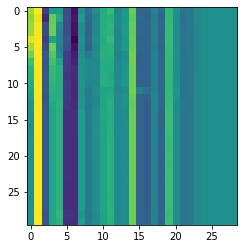

In [14]:
plt.imshow(dataD_test[30184,:,:])
plt.savefig("./picture_std/save/driverD_nopca.png",dpi=600)

In [15]:
# for i in range (13000):
#     if i%100==0:
#         plt.imshow(dataD_test[i,:,:])
#         plt.savefig("./picture_std/driver"+str(i)+".png")

In [16]:
# for i in range (13000):
#     if i%100==0:
#         plt.imshow(dataD_test[i,:,:])
#         plt.savefig("./picture_minmax/driver"+str(i)+".png")

In [17]:
# np.set_printoptions(threshold=np.inf)
dataD_test.shape

(33563, 30, 29)

In [18]:
#Generators Encoder
input_layer = layers.Input(name='input', shape=(height, width))

# Encoder
x = layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True)(input_layer)
x = layers.LSTM(64, input_length=height, input_dim=width, return_sequences=True)(x)
x = layers.LSTM(128, input_length=height, input_dim=width, return_sequences=True)(x)

x = layers.GlobalAveragePooling1D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 29)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 32)            7936      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
g_encoder_output (GlobalAver (None, 128)               0         
Total params: 131,584
Trainable params: 131,584
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Generator
input_layer = layers.Input(name='input', shape=(height, width))

x = g_e(input_layer)

y = layers.Dense(height*width, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((height, width), name='de_reshape')(y)


y = layers.LSTM(128, input_length=height, input_dim=width, return_sequences=True)(y)

y = layers.LSTM(64, input_length=height, input_dim=width, return_sequences=True)(y)

y = layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True)(y)


y = layers.TimeDistributed(layers.Dense(width, activation='tanh'))(y)


g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 29)]          0         
_________________________________________________________________
model (Functional)           (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 870)               112230    
_________________________________________________________________
de_reshape (Reshape)         (None, 30, 29)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           80896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 32)            1241

In [20]:
#Encoder
input_layer = layers.Input(name='input', shape=(height, width))

z = layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True)(input_layer)
z = layers.LSTM(64, input_length=height, input_dim=width, return_sequences=True)(z)
z = layers.LSTM(128, input_length=height, input_dim=width, return_sequences=True)(z)

z = layers.GlobalAveragePooling1D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 29)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 32)            7936      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            24832     
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
encoder_output (GlobalAverag (None, 128)               0         
Total params: 131,584
Trainable params: 131,584
Non-trainable params: 0
_________________________________________________________________


In [21]:
#feature extractor
input_layer = layers.Input(name='input', shape=(height, width))


f = layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True)(input_layer)


f = layers.LSTM(64, input_length=height, input_dim=width, return_sequences=True)(f)


f = layers.LSTM(128, input_length=height, input_dim=width, return_sequences=True)(f)



feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 29)]          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 32)            7936      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 64)            24832     
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 128)           98816     
Total params: 131,584
Trainable params: 131,584
Non-trainable params: 0
_________________________________________________________________


In [22]:
#gan trainer
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [23]:
gan_trainer.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 30, 29)]     0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 30, 29)       387491      input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              ()                   0           input[0][0]                      
                                                                 model_1[0][0]                    
__________________________________________________________________________________________________
cnt_loss (CntLoss)              ()                   0           input[0][0]                

In [24]:
#discriminator

input_layer = layers.Input(name='input', shape=(height, width))

f = feature_extractor(input_layer)
d = layers.Flatten()(f)
d = layers.GlobalAveragePooling1D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
# d = layers.Dense(1, name='d_out')(d)    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 29)]          0         
_________________________________________________________________
model_3 (Functional)         (None, 30, 128)           131584    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 131,713
Trainable params: 131,713
Non-trainable params: 0
_________________________________________________________________


In [25]:
d.compile(optimizer='adam', loss='binary_crossentropy')

In [26]:
def Evaluation(data,label,epoch):
    #Evaluation
    encoded = g_e.predict(data)
    gan_x = g.predict(data)
    encoded_gan = encoder.predict(gan_x)
    score = np.sum(np.absolute(encoded_gan - encoded), axis=-1)
    score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
#     np.save("./score/driver"+str(epoch)+"_"+str(height)+".npy", score)
#     D_L = np.empty([score.shape[0], ])
#     for i in range(score.shape[0]):
#         if score[i]>np.percentile(score, 75):
#             # true/negative
#             D_L[i] = 1
#         else:
#             # false/positive
#             D_L[i] = 0
    # fpr, tpr, thresholds = metrics.roc_curve(labelAF, D_L, pos_label = 0)
    # Auc = metrics.auc(fpr, tpr)
#     precision, recall, f1, _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')        
    rcParams['figure.figsize'] = 14, 5
    plt.scatter(range(len(score)),score, c=['skyblue' if x == 0 else 'pink' for x in label])
    plt.savefig("./plot/driver"+str(epoch)+"_"+str(height)+".png")
    plt.clf()
    plt.close()
    return score
# def Evaluation():    
#     score = np.empty([labelD_test.shape[0]])
#     for i in range(len(dataD_test)):
#         a=0
#         test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1],dataD_test[i].shape[2]])
#         dis=d(test)
#         if dis > 0:
#             a=0
#         else:
#             a=1
#         score[i]=a
#     return score

In [27]:
def save_data(x,fake_x,epoch):
    x=np.reshape(x,[x.shape[0],x.shape[1],x.shape[2]])
    fake_x=np.reshape(fake_x,[fake_x.shape[0],fake_x.shape[1],fake_x.shape[2]])
    np.save("./save_data/driver_ori"+str(epoch)+"_"+str(height)+".npy", x)
    np.save("./save_data/driver_fake"+str(epoch)+"_"+str(height)+".npy", fake_x)

In [28]:
#Training

niter = 4000
arrange=np.arange(0, niter, 1, dtype=np.int32)
bz = 64
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]        

In [29]:
def plot_loss(g_loss,d_loss):
#     plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
#     plt.plot(arrange,g_loss[:,0],'b', c='red',label = "cnt_loss")
#     plt.plot(arrange,g_loss[:,1],'b', c='blue',label = "cnt1_loss")
#     plt.plot(arrange,g_loss[:,2],'b', c='orange',label = "adv_loss")
#     plt.plot(arrange,g_loss[:,3],'b', c='green',label = "enc_loss")
#     plt.plot(arrange,d_loss, 'b',c='pink',label = "d_loss")
#     plt.xlabel("loss", fontsize=10, labelpad = 15)
#     plt.ylabel("epoch", fontsize=10, labelpad = 20)
#     plt.legend(loc = "best", fontsize=10)
#     plt.savefig("./trace/driver_"+str(height)+".png")
    np.save("./trace/driver_gloss"+str(height)+".npy", g_loss)
    np.save("./trace/driver_dloss"+str(height)+".npy", d_loss)

In [30]:
train_data_generator = get_data_generator(dataD_train, bz)

In [31]:
%%time
g_loss_plot = np.empty([niter,4])
d_loss_plot = np.empty([niter])
score1 =np.empty([labelD_test.shape[0]])
trace = open("./trace/driver_trace"+str(height)+".txt", 'w')
for i in range(niter):
    start = time.time()
    ### get batch x, y ###
    x, y = train_data_generator.__next__() 
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
        
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y)
    
    g_loss_plot[i]=g_loss
    d_loss_plot[i]=d_loss
    if i % epoch_dura == 0:
        score=Evaluation(dataD_test,labelD_test,i)
#         score=Evaluation()
        score1 = np.vstack((score1,score))
        np.save("./score/score_owner"+owner+".npy", score1)
#         save_data(x,fake_x,i)
#         trace.write(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}\n\n')
    print ('Time for epoch {} is {} sec'.format(i + 1, time.time()-start))
plot_loss(g_loss_plot,d_loss_plot)

Time for epoch 1 is 31.167352437973022 sec
Time for epoch 2 is 0.09670805931091309 sec
Time for epoch 3 is 0.09134507179260254 sec
Time for epoch 4 is 0.09485602378845215 sec
Time for epoch 5 is 0.08975982666015625 sec
Time for epoch 6 is 0.08910512924194336 sec
Time for epoch 7 is 0.0933225154876709 sec
Time for epoch 8 is 0.09582805633544922 sec
Time for epoch 9 is 0.0982515811920166 sec
Time for epoch 10 is 0.1061241626739502 sec
Time for epoch 11 is 0.09467625617980957 sec
Time for epoch 12 is 0.09580254554748535 sec
Time for epoch 13 is 0.09297847747802734 sec
Time for epoch 14 is 0.10142779350280762 sec
Time for epoch 15 is 0.09786534309387207 sec
Time for epoch 16 is 0.10189580917358398 sec
Time for epoch 17 is 0.09801435470581055 sec
Time for epoch 18 is 0.09765028953552246 sec
Time for epoch 19 is 0.10023927688598633 sec
Time for epoch 20 is 0.09913444519042969 sec
Time for epoch 21 is 0.09677600860595703 sec
Time for epoch 22 is 0.09758687019348145 sec
Time for epoch 23 is 0.

Time for epoch 185 is 0.09808135032653809 sec
Time for epoch 186 is 0.09919357299804688 sec
Time for epoch 187 is 0.10114192962646484 sec
Time for epoch 188 is 0.10072135925292969 sec
Time for epoch 189 is 0.09497189521789551 sec
Time for epoch 190 is 0.09799504280090332 sec
Time for epoch 191 is 0.09509396553039551 sec
Time for epoch 192 is 0.10272812843322754 sec
Time for epoch 193 is 0.09566807746887207 sec
Time for epoch 194 is 0.10041952133178711 sec
Time for epoch 195 is 0.0980985164642334 sec
Time for epoch 196 is 0.09456872940063477 sec
Time for epoch 197 is 0.09360027313232422 sec
Time for epoch 198 is 0.09534335136413574 sec
Time for epoch 199 is 0.09650659561157227 sec
Time for epoch 200 is 0.0982661247253418 sec
Time for epoch 201 is 14.946403741836548 sec
Time for epoch 202 is 0.09975123405456543 sec
Time for epoch 203 is 0.09361028671264648 sec
Time for epoch 204 is 0.09288454055786133 sec
Time for epoch 205 is 0.09514713287353516 sec
Time for epoch 206 is 0.0941760540008

Time for epoch 366 is 0.09686493873596191 sec
Time for epoch 367 is 0.09519219398498535 sec
Time for epoch 368 is 0.09680390357971191 sec
Time for epoch 369 is 0.10154175758361816 sec
Time for epoch 370 is 0.0985255241394043 sec
Time for epoch 371 is 0.09833598136901855 sec
Time for epoch 372 is 0.09552383422851562 sec
Time for epoch 373 is 0.09554338455200195 sec
Time for epoch 374 is 0.10147261619567871 sec
Time for epoch 375 is 0.10033655166625977 sec
Time for epoch 376 is 0.10678791999816895 sec
Time for epoch 377 is 0.10324859619140625 sec
Time for epoch 378 is 0.09797406196594238 sec
Time for epoch 379 is 0.09703969955444336 sec
Time for epoch 380 is 0.0967409610748291 sec
Time for epoch 381 is 0.09495377540588379 sec
Time for epoch 382 is 0.1001272201538086 sec
Time for epoch 383 is 0.09482073783874512 sec
Time for epoch 384 is 0.09616279602050781 sec
Time for epoch 385 is 0.09901881217956543 sec
Time for epoch 386 is 0.09929394721984863 sec
Time for epoch 387 is 0.0967409610748

Time for epoch 547 is 0.09607100486755371 sec
Time for epoch 548 is 0.09403252601623535 sec
Time for epoch 549 is 0.10039401054382324 sec
Time for epoch 550 is 0.09596490859985352 sec
Time for epoch 551 is 0.09862947463989258 sec
Time for epoch 552 is 0.09801054000854492 sec
Time for epoch 553 is 0.10104107856750488 sec
Time for epoch 554 is 0.09195613861083984 sec
Time for epoch 555 is 0.09235978126525879 sec
Time for epoch 556 is 0.09596633911132812 sec
Time for epoch 557 is 0.09389805793762207 sec
Time for epoch 558 is 0.09217596054077148 sec
Time for epoch 559 is 0.10057663917541504 sec
Time for epoch 560 is 0.09722542762756348 sec
Time for epoch 561 is 0.0969536304473877 sec
Time for epoch 562 is 0.09883999824523926 sec
Time for epoch 563 is 0.0899972915649414 sec
Time for epoch 564 is 0.09401750564575195 sec
Time for epoch 565 is 0.10000181198120117 sec
Time for epoch 566 is 0.09643125534057617 sec
Time for epoch 567 is 0.09394335746765137 sec
Time for epoch 568 is 0.093558788299

Time for epoch 727 is 0.09206938743591309 sec
Time for epoch 728 is 0.08803725242614746 sec
Time for epoch 729 is 0.08954596519470215 sec
Time for epoch 730 is 0.09381699562072754 sec
Time for epoch 731 is 0.10372424125671387 sec
Time for epoch 732 is 0.09773731231689453 sec
Time for epoch 733 is 0.1047205924987793 sec
Time for epoch 734 is 0.09873628616333008 sec
Time for epoch 735 is 0.12017989158630371 sec
Time for epoch 736 is 0.12119460105895996 sec
Time for epoch 737 is 0.11631226539611816 sec
Time for epoch 738 is 0.11168146133422852 sec
Time for epoch 739 is 0.11397361755371094 sec
Time for epoch 740 is 0.10522747039794922 sec
Time for epoch 741 is 0.10871005058288574 sec
Time for epoch 742 is 0.10123610496520996 sec
Time for epoch 743 is 0.1077120304107666 sec
Time for epoch 744 is 0.11021208763122559 sec
Time for epoch 745 is 0.10970687866210938 sec
Time for epoch 746 is 0.10722041130065918 sec
Time for epoch 747 is 0.10522627830505371 sec
Time for epoch 748 is 0.110704660415

Time for epoch 906 is 0.10607528686523438 sec
Time for epoch 907 is 0.10162472724914551 sec
Time for epoch 908 is 0.10745406150817871 sec
Time for epoch 909 is 0.10671472549438477 sec
Time for epoch 910 is 0.11271238327026367 sec
Time for epoch 911 is 0.10354757308959961 sec
Time for epoch 912 is 0.10349798202514648 sec
Time for epoch 913 is 0.1097567081451416 sec
Time for epoch 914 is 0.10345172882080078 sec
Time for epoch 915 is 0.10272598266601562 sec
Time for epoch 916 is 0.11041378974914551 sec
Time for epoch 917 is 0.10720944404602051 sec
Time for epoch 918 is 0.10925793647766113 sec
Time for epoch 919 is 0.10470867156982422 sec
Time for epoch 920 is 0.1087801456451416 sec
Time for epoch 921 is 0.11076641082763672 sec
Time for epoch 922 is 0.10445642471313477 sec
Time for epoch 923 is 0.10638809204101562 sec
Time for epoch 924 is 0.1045370101928711 sec
Time for epoch 925 is 0.10822224617004395 sec
Time for epoch 926 is 0.10626220703125 sec
Time for epoch 927 is 0.1121244430541992

Time for epoch 1084 is 0.10212588310241699 sec
Time for epoch 1085 is 0.09989428520202637 sec
Time for epoch 1086 is 0.10523319244384766 sec
Time for epoch 1087 is 0.10716652870178223 sec
Time for epoch 1088 is 0.1044313907623291 sec
Time for epoch 1089 is 0.10634469985961914 sec
Time for epoch 1090 is 0.10908365249633789 sec
Time for epoch 1091 is 0.10886001586914062 sec
Time for epoch 1092 is 0.10283017158508301 sec
Time for epoch 1093 is 0.10681915283203125 sec
Time for epoch 1094 is 0.10450458526611328 sec
Time for epoch 1095 is 0.10369539260864258 sec
Time for epoch 1096 is 0.1140742301940918 sec
Time for epoch 1097 is 0.11299014091491699 sec
Time for epoch 1098 is 0.10693717002868652 sec
Time for epoch 1099 is 0.10293722152709961 sec
Time for epoch 1100 is 0.10658812522888184 sec
Time for epoch 1101 is 15.783631563186646 sec
Time for epoch 1102 is 0.09027671813964844 sec
Time for epoch 1103 is 0.10144448280334473 sec
Time for epoch 1104 is 0.10593891143798828 sec
Time for epoch 1

Time for epoch 1259 is 0.09728288650512695 sec
Time for epoch 1260 is 0.0942373275756836 sec
Time for epoch 1261 is 0.09199404716491699 sec
Time for epoch 1262 is 0.09327983856201172 sec
Time for epoch 1263 is 0.0912618637084961 sec
Time for epoch 1264 is 0.09075784683227539 sec
Time for epoch 1265 is 0.09275221824645996 sec
Time for epoch 1266 is 0.08979415893554688 sec
Time for epoch 1267 is 0.0887289047241211 sec
Time for epoch 1268 is 0.09873557090759277 sec
Time for epoch 1269 is 0.09474658966064453 sec
Time for epoch 1270 is 0.0987706184387207 sec
Time for epoch 1271 is 0.09954524040222168 sec
Time for epoch 1272 is 0.09774065017700195 sec
Time for epoch 1273 is 0.09075713157653809 sec
Time for epoch 1274 is 0.09337282180786133 sec
Time for epoch 1275 is 0.0958855152130127 sec
Time for epoch 1276 is 0.08556175231933594 sec
Time for epoch 1277 is 0.08178210258483887 sec
Time for epoch 1278 is 0.10103178024291992 sec
Time for epoch 1279 is 0.09407472610473633 sec
Time for epoch 128

Time for epoch 1435 is 0.09178519248962402 sec
Time for epoch 1436 is 0.0877373218536377 sec
Time for epoch 1437 is 0.08702588081359863 sec
Time for epoch 1438 is 0.08855652809143066 sec
Time for epoch 1439 is 0.0846095085144043 sec
Time for epoch 1440 is 0.08582496643066406 sec
Time for epoch 1441 is 0.08687758445739746 sec
Time for epoch 1442 is 0.08662295341491699 sec
Time for epoch 1443 is 0.08981132507324219 sec
Time for epoch 1444 is 0.08572936058044434 sec
Time for epoch 1445 is 0.08830451965332031 sec
Time for epoch 1446 is 0.0834970474243164 sec
Time for epoch 1447 is 0.08567237854003906 sec
Time for epoch 1448 is 0.08678388595581055 sec
Time for epoch 1449 is 0.08369064331054688 sec
Time for epoch 1450 is 0.07797765731811523 sec
Time for epoch 1451 is 0.08776688575744629 sec
Time for epoch 1452 is 0.0885324478149414 sec
Time for epoch 1453 is 0.09227299690246582 sec
Time for epoch 1454 is 0.08780360221862793 sec
Time for epoch 1455 is 0.08776521682739258 sec
Time for epoch 14

Time for epoch 1611 is 0.10921549797058105 sec
Time for epoch 1612 is 0.11273550987243652 sec
Time for epoch 1613 is 0.10061001777648926 sec
Time for epoch 1614 is 0.10445332527160645 sec
Time for epoch 1615 is 0.10718083381652832 sec
Time for epoch 1616 is 0.10838556289672852 sec
Time for epoch 1617 is 0.1082608699798584 sec
Time for epoch 1618 is 0.10287070274353027 sec
Time for epoch 1619 is 0.11107063293457031 sec
Time for epoch 1620 is 0.10870862007141113 sec
Time for epoch 1621 is 0.10023951530456543 sec
Time for epoch 1622 is 0.10214805603027344 sec
Time for epoch 1623 is 0.10570907592773438 sec
Time for epoch 1624 is 0.09674572944641113 sec
Time for epoch 1625 is 0.10438704490661621 sec
Time for epoch 1626 is 0.10544013977050781 sec
Time for epoch 1627 is 0.10527491569519043 sec
Time for epoch 1628 is 0.10578370094299316 sec
Time for epoch 1629 is 0.10571765899658203 sec
Time for epoch 1630 is 0.09973287582397461 sec
Time for epoch 1631 is 0.10073065757751465 sec
Time for epoch

Time for epoch 1788 is 0.09881472587585449 sec
Time for epoch 1789 is 0.09305119514465332 sec
Time for epoch 1790 is 0.09393095970153809 sec
Time for epoch 1791 is 0.09325909614562988 sec
Time for epoch 1792 is 0.09229111671447754 sec
Time for epoch 1793 is 0.09261035919189453 sec
Time for epoch 1794 is 0.09118413925170898 sec
Time for epoch 1795 is 0.08880305290222168 sec
Time for epoch 1796 is 0.0963907241821289 sec
Time for epoch 1797 is 0.09478569030761719 sec
Time for epoch 1798 is 0.08876228332519531 sec
Time for epoch 1799 is 0.09175515174865723 sec
Time for epoch 1800 is 0.09033536911010742 sec
Time for epoch 1801 is 14.013152360916138 sec
Time for epoch 1802 is 0.0936732292175293 sec
Time for epoch 1803 is 0.10172843933105469 sec
Time for epoch 1804 is 0.09215307235717773 sec
Time for epoch 1805 is 0.09279394149780273 sec
Time for epoch 1806 is 0.091827392578125 sec
Time for epoch 1807 is 0.09371113777160645 sec
Time for epoch 1808 is 0.09430670738220215 sec
Time for epoch 180

Time for epoch 1964 is 0.09082603454589844 sec
Time for epoch 1965 is 0.09282732009887695 sec
Time for epoch 1966 is 0.08903384208679199 sec
Time for epoch 1967 is 0.08976197242736816 sec
Time for epoch 1968 is 0.08288192749023438 sec
Time for epoch 1969 is 0.07915449142456055 sec
Time for epoch 1970 is 0.09075689315795898 sec
Time for epoch 1971 is 0.09574460983276367 sec
Time for epoch 1972 is 0.08317899703979492 sec
Time for epoch 1973 is 0.09413313865661621 sec
Time for epoch 1974 is 0.09275197982788086 sec
Time for epoch 1975 is 0.09275293350219727 sec
Time for epoch 1976 is 0.08277750015258789 sec
Time for epoch 1977 is 0.0897359848022461 sec
Time for epoch 1978 is 0.09031271934509277 sec
Time for epoch 1979 is 0.09774160385131836 sec
Time for epoch 1980 is 0.09084033966064453 sec
Time for epoch 1981 is 0.09344673156738281 sec
Time for epoch 1982 is 0.0881047248840332 sec
Time for epoch 1983 is 0.0917823314666748 sec
Time for epoch 1984 is 0.09977030754089355 sec
Time for epoch 1

Time for epoch 2142 is 0.09175419807434082 sec
Time for epoch 2143 is 0.08827352523803711 sec
Time for epoch 2144 is 0.09487247467041016 sec
Time for epoch 2145 is 0.09476017951965332 sec
Time for epoch 2146 is 0.08470320701599121 sec
Time for epoch 2147 is 0.08998537063598633 sec
Time for epoch 2148 is 0.09676694869995117 sec
Time for epoch 2149 is 0.09873557090759277 sec
Time for epoch 2150 is 0.09075736999511719 sec
Time for epoch 2151 is 0.09175491333007812 sec
Time for epoch 2152 is 0.09362959861755371 sec
Time for epoch 2153 is 0.09590530395507812 sec
Time for epoch 2154 is 0.09379076957702637 sec
Time for epoch 2155 is 0.08876252174377441 sec
Time for epoch 2156 is 0.09444952011108398 sec
Time for epoch 2157 is 0.09269094467163086 sec
Time for epoch 2158 is 0.09529447555541992 sec
Time for epoch 2159 is 0.09522581100463867 sec
Time for epoch 2160 is 0.08727335929870605 sec
Time for epoch 2161 is 0.09020662307739258 sec
Time for epoch 2162 is 0.09749841690063477 sec
Time for epoc

Time for epoch 2319 is 0.09584307670593262 sec
Time for epoch 2320 is 0.08176183700561523 sec
Time for epoch 2321 is 0.08837532997131348 sec
Time for epoch 2322 is 0.08773207664489746 sec
Time for epoch 2323 is 0.09469342231750488 sec
Time for epoch 2324 is 0.08649277687072754 sec
Time for epoch 2325 is 0.09254217147827148 sec
Time for epoch 2326 is 0.09984683990478516 sec
Time for epoch 2327 is 0.09159445762634277 sec
Time for epoch 2328 is 0.0887916088104248 sec
Time for epoch 2329 is 0.09201383590698242 sec
Time for epoch 2330 is 0.09265494346618652 sec
Time for epoch 2331 is 0.0913691520690918 sec
Time for epoch 2332 is 0.09014678001403809 sec
Time for epoch 2333 is 0.09224677085876465 sec
Time for epoch 2334 is 0.0912163257598877 sec
Time for epoch 2335 is 0.09685492515563965 sec
Time for epoch 2336 is 0.09790182113647461 sec
Time for epoch 2337 is 0.09065127372741699 sec
Time for epoch 2338 is 0.09325504302978516 sec
Time for epoch 2339 is 0.09761381149291992 sec
Time for epoch 2

Time for epoch 2496 is 0.1097116470336914 sec
Time for epoch 2497 is 0.11034393310546875 sec
Time for epoch 2498 is 0.1077122688293457 sec
Time for epoch 2499 is 0.10963225364685059 sec
Time for epoch 2500 is 0.09823966026306152 sec
Time for epoch 2501 is 14.8863365650177 sec
Time for epoch 2502 is 0.09773898124694824 sec
Time for epoch 2503 is 0.09946179389953613 sec
Time for epoch 2504 is 0.10256838798522949 sec
Time for epoch 2505 is 0.09991884231567383 sec
Time for epoch 2506 is 0.10448265075683594 sec
Time for epoch 2507 is 0.09574508666992188 sec
Time for epoch 2508 is 0.10970592498779297 sec
Time for epoch 2509 is 0.1007695198059082 sec
Time for epoch 2510 is 0.10671544075012207 sec
Time for epoch 2511 is 0.10870885848999023 sec
Time for epoch 2512 is 0.10259389877319336 sec
Time for epoch 2513 is 0.10566568374633789 sec
Time for epoch 2514 is 0.10277080535888672 sec
Time for epoch 2515 is 0.09877514839172363 sec
Time for epoch 2516 is 0.0997626781463623 sec
Time for epoch 2517 

Time for epoch 2674 is 0.09222269058227539 sec
Time for epoch 2675 is 0.09344482421875 sec
Time for epoch 2676 is 0.09227919578552246 sec
Time for epoch 2677 is 0.09406471252441406 sec
Time for epoch 2678 is 0.09273815155029297 sec
Time for epoch 2679 is 0.09254670143127441 sec
Time for epoch 2680 is 0.09712576866149902 sec
Time for epoch 2681 is 0.0927126407623291 sec
Time for epoch 2682 is 0.09191560745239258 sec
Time for epoch 2683 is 0.09081196784973145 sec
Time for epoch 2684 is 0.09227561950683594 sec
Time for epoch 2685 is 0.09227776527404785 sec
Time for epoch 2686 is 0.09028315544128418 sec
Time for epoch 2687 is 0.09851503372192383 sec
Time for epoch 2688 is 0.08826994895935059 sec
Time for epoch 2689 is 0.08967924118041992 sec
Time for epoch 2690 is 0.08979415893554688 sec
Time for epoch 2691 is 0.09064865112304688 sec
Time for epoch 2692 is 0.0897359848022461 sec
Time for epoch 2693 is 0.09387993812561035 sec
Time for epoch 2694 is 0.09163808822631836 sec
Time for epoch 269

Time for epoch 2850 is 0.0908041000366211 sec
Time for epoch 2851 is 0.09774422645568848 sec
Time for epoch 2852 is 0.09044432640075684 sec
Time for epoch 2853 is 0.09267902374267578 sec
Time for epoch 2854 is 0.09465813636779785 sec
Time for epoch 2855 is 0.0916743278503418 sec
Time for epoch 2856 is 0.09275126457214355 sec
Time for epoch 2857 is 0.09215474128723145 sec
Time for epoch 2858 is 0.0929419994354248 sec
Time for epoch 2859 is 0.10068440437316895 sec
Time for epoch 2860 is 0.09653925895690918 sec
Time for epoch 2861 is 0.09521627426147461 sec
Time for epoch 2862 is 0.09583783149719238 sec
Time for epoch 2863 is 0.09775137901306152 sec
Time for epoch 2864 is 0.08876299858093262 sec
Time for epoch 2865 is 0.09006214141845703 sec
Time for epoch 2866 is 0.09581685066223145 sec
Time for epoch 2867 is 0.09740877151489258 sec
Time for epoch 2868 is 0.09402680397033691 sec
Time for epoch 2869 is 0.09206390380859375 sec
Time for epoch 2870 is 0.09361958503723145 sec
Time for epoch 2

Time for epoch 3028 is 0.0942838191986084 sec
Time for epoch 3029 is 0.09275460243225098 sec
Time for epoch 3030 is 0.09275460243225098 sec
Time for epoch 3031 is 0.09429764747619629 sec
Time for epoch 3032 is 0.09298205375671387 sec
Time for epoch 3033 is 0.08700275421142578 sec
Time for epoch 3034 is 0.0900125503540039 sec
Time for epoch 3035 is 0.09315276145935059 sec
Time for epoch 3036 is 0.09421825408935547 sec
Time for epoch 3037 is 0.0928652286529541 sec
Time for epoch 3038 is 0.09206271171569824 sec
Time for epoch 3039 is 0.09204435348510742 sec
Time for epoch 3040 is 0.0954439640045166 sec
Time for epoch 3041 is 0.0901181697845459 sec
Time for epoch 3042 is 0.09659934043884277 sec
Time for epoch 3043 is 0.0902411937713623 sec
Time for epoch 3044 is 0.1006767749786377 sec
Time for epoch 3045 is 0.09182167053222656 sec
Time for epoch 3046 is 0.09369850158691406 sec
Time for epoch 3047 is 0.08930277824401855 sec
Time for epoch 3048 is 0.08976030349731445 sec
Time for epoch 3049 

Time for epoch 3204 is 0.0936422348022461 sec
Time for epoch 3205 is 0.0827784538269043 sec
Time for epoch 3206 is 0.09175491333007812 sec
Time for epoch 3207 is 0.08876252174377441 sec
Time for epoch 3208 is 0.09407448768615723 sec
Time for epoch 3209 is 0.0877678394317627 sec
Time for epoch 3210 is 0.09470272064208984 sec
Time for epoch 3211 is 0.09596991539001465 sec
Time for epoch 3212 is 0.08891844749450684 sec
Time for epoch 3213 is 0.08614659309387207 sec
Time for epoch 3214 is 0.08052635192871094 sec
Time for epoch 3215 is 0.0917961597442627 sec
Time for epoch 3216 is 0.08513808250427246 sec
Time for epoch 3217 is 0.09097099304199219 sec
Time for epoch 3218 is 0.0967414379119873 sec
Time for epoch 3219 is 0.09547567367553711 sec
Time for epoch 3220 is 0.0932929515838623 sec
Time for epoch 3221 is 0.08781838417053223 sec
Time for epoch 3222 is 0.08514261245727539 sec
Time for epoch 3223 is 0.08815836906433105 sec
Time for epoch 3224 is 0.09308671951293945 sec
Time for epoch 3225

Time for epoch 3382 is 0.09480118751525879 sec
Time for epoch 3383 is 0.08939528465270996 sec
Time for epoch 3384 is 0.09169459342956543 sec
Time for epoch 3385 is 0.0908653736114502 sec
Time for epoch 3386 is 0.09375190734863281 sec
Time for epoch 3387 is 0.0865476131439209 sec
Time for epoch 3388 is 0.09075808525085449 sec
Time for epoch 3389 is 0.09473037719726562 sec
Time for epoch 3390 is 0.0936436653137207 sec
Time for epoch 3391 is 0.09523653984069824 sec
Time for epoch 3392 is 0.08633899688720703 sec
Time for epoch 3393 is 0.08584189414978027 sec
Time for epoch 3394 is 0.08652162551879883 sec
Time for epoch 3395 is 0.09500432014465332 sec
Time for epoch 3396 is 0.09339642524719238 sec
Time for epoch 3397 is 0.09177947044372559 sec
Time for epoch 3398 is 0.09106087684631348 sec
Time for epoch 3399 is 0.09274506568908691 sec
Time for epoch 3400 is 0.09087824821472168 sec
Time for epoch 3401 is 13.975616931915283 sec
Time for epoch 3402 is 0.09474587440490723 sec
Time for epoch 34

Time for epoch 3559 is 0.08979439735412598 sec
Time for epoch 3560 is 0.08776497840881348 sec
Time for epoch 3561 is 0.08889579772949219 sec
Time for epoch 3562 is 0.09046196937561035 sec
Time for epoch 3563 is 0.09430098533630371 sec
Time for epoch 3564 is 0.09892964363098145 sec
Time for epoch 3565 is 0.0907590389251709 sec
Time for epoch 3566 is 0.09574484825134277 sec
Time for epoch 3567 is 0.0879068374633789 sec
Time for epoch 3568 is 0.09075689315795898 sec
Time for epoch 3569 is 0.09106683731079102 sec
Time for epoch 3570 is 0.09011149406433105 sec
Time for epoch 3571 is 0.08888888359069824 sec
Time for epoch 3572 is 0.09073996543884277 sec
Time for epoch 3573 is 0.09180879592895508 sec
Time for epoch 3574 is 0.0910799503326416 sec
Time for epoch 3575 is 0.09352803230285645 sec
Time for epoch 3576 is 0.09259271621704102 sec
Time for epoch 3577 is 0.09271049499511719 sec
Time for epoch 3578 is 0.08681440353393555 sec
Time for epoch 3579 is 0.09724044799804688 sec
Time for epoch 3

Time for epoch 3734 is 0.10117077827453613 sec
Time for epoch 3735 is 0.09847283363342285 sec
Time for epoch 3736 is 0.10754036903381348 sec
Time for epoch 3737 is 0.10571670532226562 sec
Time for epoch 3738 is 0.1042478084564209 sec
Time for epoch 3739 is 0.10430073738098145 sec
Time for epoch 3740 is 0.1022334098815918 sec
Time for epoch 3741 is 0.11245036125183105 sec
Time for epoch 3742 is 0.10692906379699707 sec
Time for epoch 3743 is 0.10167860984802246 sec
Time for epoch 3744 is 0.11078763008117676 sec
Time for epoch 3745 is 0.10188150405883789 sec
Time for epoch 3746 is 0.10736083984375 sec
Time for epoch 3747 is 0.10568904876708984 sec
Time for epoch 3748 is 0.1057288646697998 sec
Time for epoch 3749 is 0.10982322692871094 sec
Time for epoch 3750 is 0.10672974586486816 sec
Time for epoch 3751 is 0.10955548286437988 sec
Time for epoch 3752 is 0.10447812080383301 sec
Time for epoch 3753 is 0.10605406761169434 sec
Time for epoch 3754 is 0.10372257232666016 sec
Time for epoch 3755

Time for epoch 3910 is 0.10506391525268555 sec
Time for epoch 3911 is 0.0889592170715332 sec
Time for epoch 3912 is 0.09131002426147461 sec
Time for epoch 3913 is 0.09415388107299805 sec
Time for epoch 3914 is 0.08832883834838867 sec
Time for epoch 3915 is 0.09380054473876953 sec
Time for epoch 3916 is 0.09481120109558105 sec
Time for epoch 3917 is 0.09011554718017578 sec
Time for epoch 3918 is 0.09607791900634766 sec
Time for epoch 3919 is 0.09586524963378906 sec
Time for epoch 3920 is 0.0933077335357666 sec
Time for epoch 3921 is 0.09313058853149414 sec
Time for epoch 3922 is 0.09384942054748535 sec
Time for epoch 3923 is 0.09376835823059082 sec
Time for epoch 3924 is 0.0959329605102539 sec
Time for epoch 3925 is 0.09118938446044922 sec
Time for epoch 3926 is 0.09657096862792969 sec
Time for epoch 3927 is 0.09779763221740723 sec
Time for epoch 3928 is 0.09528970718383789 sec
Time for epoch 3929 is 0.0947561264038086 sec
Time for epoch 3930 is 0.09409379959106445 sec
Time for epoch 39

In [49]:
D_L = np.empty([score1.shape[1]])
precisiona = np.empty([score1.shape[0]-1])
recalla = np.empty([score1.shape[0]-1])
f1a = np.empty([score1.shape[0]-1])
acca = np.empty([score1.shape[0]-1])
for j in range (score1.shape[0]-1):
    for i in range(score1.shape[1]):
        if score1[j+1][i]>0.18:
            # true/negative
            D_L[i] = 1
        else:
            # false/positive
            D_L[i] = 0
    precisiona[j], recalla[j], f1a[j], _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')
    acca[j] = accuracy_score(labelD_test, D_L)

In [50]:
# start = time.time()
# encoded = g_e.predict(dataD_test)
# gan_x = g.predict(dataD_test)
# encoded_gan = g_e.predict(gan_x)
# score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
# score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
# print ('Time for epoch {} is {} sec'.format(1, time.time()-start))

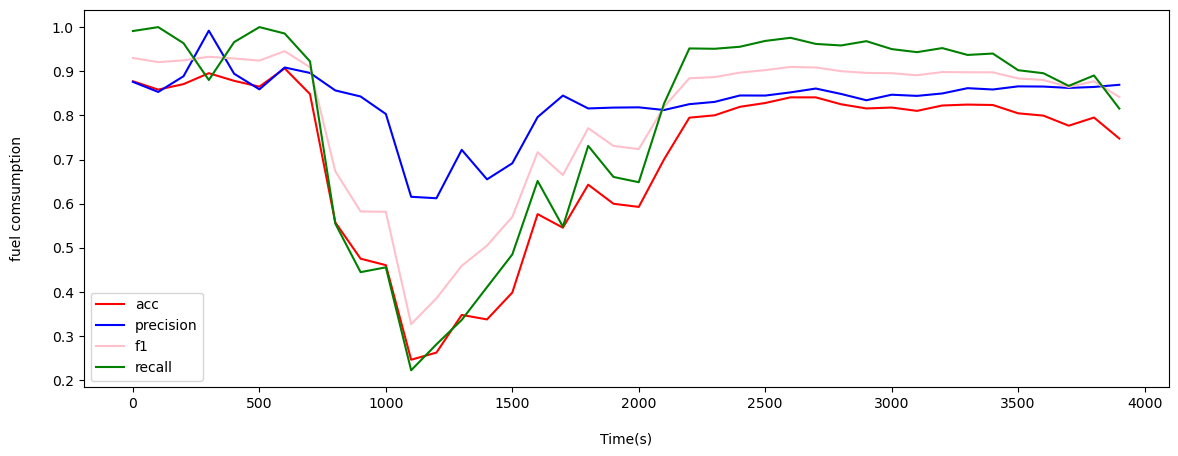

In [51]:
arrange=np.arange(0, 4000, 100, dtype=np.int32)
# arrange1=np.arange(0, 4000, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange,acca,'b', c='red',label = "acc")
plt.plot(arrange,precisiona,'b', c='blue',label = "precision")
plt.plot(arrange,f1a,'b', c='pink',label = "f1")
plt.plot(arrange,recalla,'b', c='green',label = "recall")
# plt.plot(arrange1,g_loss_plot[:,3], 'b',c='black',label = "g_loss")
# plt.plot(arrange1,d_loss_plot, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

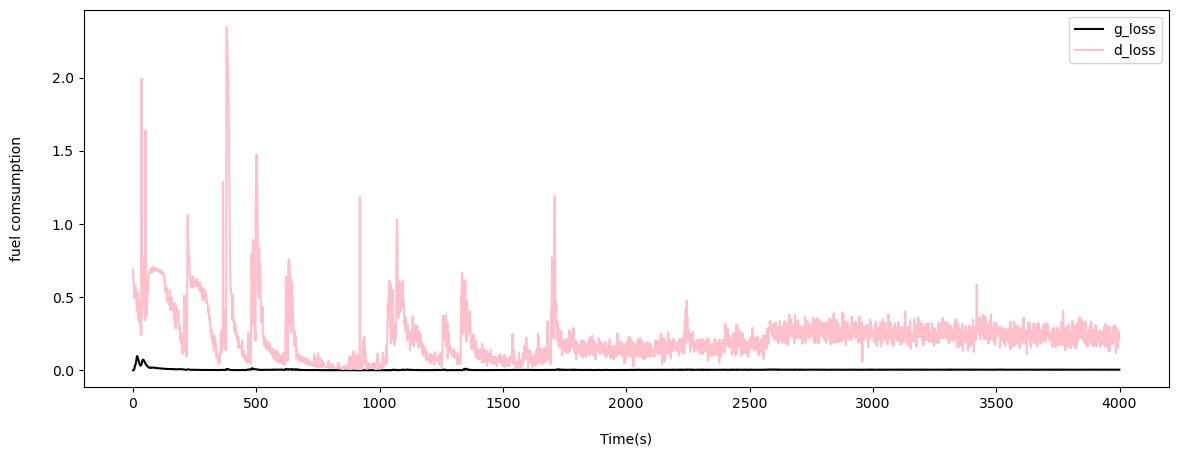

In [35]:
arrange1=np.arange(0, 4000, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange1,g_loss_plot[:,3], 'b',c='black',label = "g_loss")
plt.plot(arrange1,d_loss_plot, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

In [48]:
acca

array([0.87980812, 0.87489199, 0.86678783, 0.85099663, 0.85829634,
       0.88529035, 0.88770372, 0.72901707, 0.46250335, 0.36158865,
       0.32646069, 0.21565414, 0.22340077, 0.29428239, 0.21052945,
       0.19542353, 0.53085243, 0.45568036, 0.55531389, 0.51744481,
       0.48675625, 0.60545839, 0.75684534, 0.76915055, 0.81583887,
       0.8416113 , 0.87724578, 0.84900039, 0.81315735, 0.82173822,
       0.8128594 , 0.79498257, 0.81050562, 0.7863719 , 0.8004648 ,
       0.74403361, 0.70872687, 0.67011292, 0.71018681, 0.6115961 ])

In [37]:
precisiona

array([0.93750989, 0.93143882, 1.        , 1.        , 0.94436271,
       1.        , 1.        , 0.99540816, 1.        , 1.        ,
       1.        , 0.97883598, 0.43589744, 0.74061433, 0.31050955,
       0.03740648, 0.76489899, 0.71305961, 0.94778232, 0.93874773,
       0.98466699, 0.92380952, 0.75912409, 0.98102744, 1.        ,
       0.99983956, 1.        , 0.98484495, 0.98235766, 0.97924588,
       0.97717522, 0.96038196, 0.95423341, 0.96040076, 0.95434162,
       0.96520097, 0.95762954, 0.94625783, 0.94441771, 0.95777351])

In [38]:
f1a

array([0.34947219, 0.82107823, 0.63224943, 0.64307844, 0.66383059,
       0.85541844, 0.54815711, 0.24764383, 0.13283259, 0.11368608,
       0.04658242, 0.02645597, 0.00733101, 0.01556337, 0.0138195 ,
       0.0060002 , 0.19199442, 0.19270311, 0.19582738, 0.13887304,
       0.13847709, 0.13672059, 0.20251256, 0.39030338, 0.26834855,
       0.36847395, 0.21398751, 0.2649771 , 0.23456948, 0.36460699,
       0.34075404, 0.29075811, 0.30477815, 0.25332704, 0.28813194,
       0.2286262 , 0.21520942, 0.18742245, 0.24725188, 0.16524273])

In [39]:
recalla

array([0.21476461, 0.73409923, 0.46225492, 0.47392455, 0.51179647,
       0.74736346, 0.37755953, 0.14141268, 0.07114123, 0.06026891,
       0.02384663, 0.0134092 , 0.00369659, 0.00786431, 0.00706701,
       0.0032617 , 0.10977422, 0.11140507, 0.10919436, 0.07498279,
       0.07447541, 0.07382307, 0.11684123, 0.24361251, 0.15496684,
       0.22585438, 0.119813  , 0.1530823 , 0.13318595, 0.22400609,
       0.20635668, 0.17131156, 0.18135034, 0.14590657, 0.16968072,
       0.12967057, 0.1212264 , 0.10401189, 0.14224622, 0.09042148])

In [40]:
# scorea=np.load('./score/ownerB/score_ownerB.npy',allow_pickle=True)
# labela_test=np.load('./score/ownerB/label_ownerB.npy',allow_pickle=True)
# scoreb=np.load('./score/ownerB/score_ownerB.npy',allow_pickle=True)
# labelb_test=np.load('./score/ownerB/label_ownerB.npy',allow_pickle=True)
# scorec=np.load('./score/ownerC/score_ownerC.npy',allow_pickle=True)
# labelc_test=np.load('./score/ownerC/label_ownerC.npy',allow_pickle=True)
# scored=np.load('./score/ownerD/score_ownerD.npy',allow_pickle=True)
# labeld_test=np.load('./score/ownerD/label_ownerD.npy',allow_pickle=True)